<a href="https://colab.research.google.com/github/peyman886/Deep_Learning_course/blob/main/HW2_practical_Q1%2C2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

======================================================
### **Student Information:**
* Name = Peyman
* Last Name = Naseri
* ID = 96100522

======================================================

# Importing

In [1]:
# import shutil
# path = './model'
# shutil.rmtree(path)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *


from tensorflow.keras.callbacks import TensorBoard
# Load the TensorBoard notebook extension (to be able to see it in the notebook).
%load_ext tensorboard
import datetime   # to organize TensorBoard files

# import os
# os.environ['AUTOGRAPH_VERBOSITY'] = '5'
# # Verbosity is now 5

# tf.autograph.set_verbosity(0)
# # Verbosity is now 0
tf.get_logger().setLevel('ERROR')

In [3]:
'''
  https://research.google.com/colaboratory/local-runtimes.html
  
  for run code on local gpu:
    run this comand in anaconda prompet:
      1) pip install jupyter_http_over_ws
      2) jupyter serverextension enable --py jupyter_http_over_ws
      3) jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' --port=8888 --NotebookApp.port_retries=0

pip install jupyter_http_over_ws
jupyter serverextension enable --py jupyter_http_over_ws
jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' --port=8888 --NotebookApp.port_retries=0

    copy url and paste on colab

'''
#Check GPU

if len(tf.config.list_physical_devices('GPU')) > 0:
  !nvidia-smi --query-gpu=gpu_name,driver_version,memory.total --format=csv

name, driver_version, memory.total [MiB]
GeForce RTX 2080 with Max-Q Design, 460.89, 8192 MiB


# DATA

## Downloading datasets


In [4]:
(X, y), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

## Show 

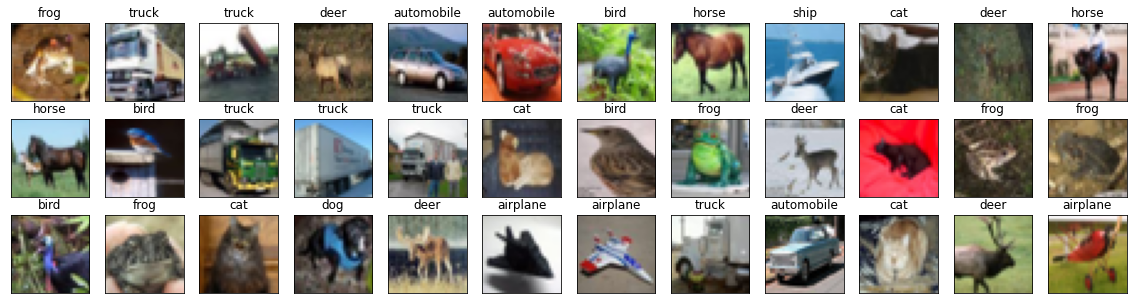

In [5]:
## show a few sample of dataset
# the images are matrices itself, meaning we will use numpy to read them in and matplotlib to "plot" them. 

d = {
    0:'airplane',
    1:'automobile',
    2:'bird',
    3:'cat',
    4:'deer',
    5:'dog', 
    6:'frog',
    7:'horse',
    8:'ship', 
    9:'truck'
    }
def plot_images(X,y):
    fig = plt.figure(figsize=(20,5))
    for i in range(36):
        ax = fig.add_subplot(3, 12, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(X[i]))
        ax.set_title(d[y[i][0]])
plot_images(X=X, y=y)


## One Hot encoding

In [6]:
# from keras.utils import np_utils/
# import keras.utils.to_categorical as to_categorical
# from keras.utils import to_categorical

num_classes = len(np.unique(y))
y = keras.utils.to_categorical(y, num_classes)
# y_train = keras.utils.to_categorical(y_train, num_classes)
# y_valid = keras.utils.to_categorical(y_valid, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

X = X.astype('float32')
X_test = X_test.astype('float32')

## Split 

In [7]:
#split orginal data into training and validation sets 
from sklearn.model_selection import train_test_split 
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=43, shuffle=True)
print('shape X_train:', X_train.shape)
print('shape X_valid:', X_valid.shape)
print('shape X_test:', X_test.shape)
print()
print('shape y_train:', y_train.shape)
print('shape y_valid:', y_valid.shape)
print('shape y_test:', y_test.shape)


shape X_train: (40000, 32, 32, 3)
shape X_valid: (10000, 32, 32, 3)
shape X_test: (10000, 32, 32, 3)

shape y_train: (40000, 10)
shape y_valid: (10000, 10)
shape y_test: (10000, 10)


## Normalization

In [8]:


X_train = keras.utils.normalize(X_train, axis=1)
X_valid = keras.utils.normalize(X_valid, axis=1)
X_test = keras.utils.normalize(X_test, axis=1)

# X_train /= 255
# X_valid /= 255
# X_test /= 255

# Network

## building MLP

In [9]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation

import time

#create a fully conected layer
def add_FC_layer(model, units, activation='relu',
                 has_batchNormalization=False, has_dropout=False, dropout_rate=0.2):
  model.add(Dense(units=units))
  if has_batchNormalization:
      model.add(BatchNormalization())
  model.add(Activation(activation))
  if has_dropout:
    model.add(Dropout(dropout_rate))
  return model

#create a MLP without input layer
def FC_net(model, num_layer=3, shape=(128, 256, 512), activation='relu',
           has_batchNormalization=False, has_dropout=False, dropout_rate=0.5):
  for i in range(num_layer):
    model = add_FC_layer(model=model,units=shape[i],
                         has_batchNormalization=has_batchNormalization,
                         has_dropout=has_dropout, dropout_rate=dropout_rate)
  model.add(Dense(num_classes, activation='softmax'))
  model.summary()
  return model          

def build_MLP(name, activation='relu'):
  model = Sequential(name=name)
  model.add(Flatten(input_shape = X_train.shape[1:]))
  model = FC_net(model=model, activation=activation)
  model.summary()
  return model

## building CNN

In [10]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras import regularizers
# create conv layer
def add_conv_layer(model, filters, kernel_size=3, strides=1, activation='relu', is_first_layer=False,
                   has_batchNormalization=False, has_pooling=False, has_dropout=False,dropout_rate=0.2):
  weight_decay = 1e-4
  if is_first_layer:
    model.add(Conv2D(filters=filters, kernel_size=kernel_size, strides=strides,
                     kernel_regularizer=regularizers.l2(weight_decay),
                     activation=activation,
                    padding='same', input_shape = X_train.shape[1:]))
  else:
    model.add(Conv2D(filters=filters, kernel_size=kernel_size,
                     kernel_regularizer=regularizers.l2(weight_decay),
                     activation=activation,
                     strides=strides, padding='same'))
  if has_batchNormalization:
    model.add(BatchNormalization())
  # model.add(Activation(activation))
  if has_pooling:
    model.add(MaxPooling2D(pool_size=2))
  if has_dropout:
    model.add(Dropout(dropout_rate))
  return model

def build_CNN(name,num_layer=6,shape=(32,32,64,64,128,128), activation='relu',
              has_batchNormalization=False, has_pooling=False, has_dropout=False, dropout_rate=0.2):
  #CNN part:
  model = Sequential(name=name)
  model = add_conv_layer(model, filters=shape[0], is_first_layer=True,
                         has_batchNormalization=has_batchNormalization)
                        #  has_pooling=has_pooling)
  for i in range(1,num_layer):
    # use pooling in even layers
    if i%2==1:
      model = add_conv_layer(model=model,filters=shape[i],
                            has_batchNormalization=has_batchNormalization,
                            has_pooling=has_pooling,
                            has_dropout=has_dropout, dropout_rate=0.2)
    else:
      model = add_conv_layer(model=model,filters=shape[i],
                            has_batchNormalization=has_batchNormalization,
                            has_dropout=has_dropout, dropout_rate=0.2)

  
  # if has_pooling:x  
  # model.add(GlobalAveragePooling2D())
  model.add(Flatten())
  #FC part:  
  # model.summary()
  return model

## concatenating a MLP model to a CNN model

In [11]:
# def add_mlp_(mlp, cnn, trainabling=False,
#                   has_batchNormalization_mlp=False,
#                   has_dropout_mlp=False, dropout_rate_mlp=0.5):
  
  #load pre-trained weights mlp model
  # filepath = './model/'+ mlp.name 
  # mlp.load_weights(filepath)

# for layer in mlp.layers[1:]: cnn.add(layer)
#   # layer.trainable = trainabling Freeze all layers except the last one.
# # cnn.add(mlp.layers[-1])
#   cnn.summary()
  # return cnn


## compiling model

In [12]:
def compiling(model, loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy']):
    if optimizer=='sgd':
      optimizer = tf.keras.optimizers.SGD()
    else:
      optimizer = tf.keras.optimizers.Adam(
          learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False)
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model

## callback functions

In [13]:
# from IPython.display import clear_output

class PlotLearning(keras.callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def __init__(self, report_every=50, dot_every=1):
        self.report_every = report_every
        self.dot_every = dot_every
        
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        # Plotting
        metrics = [x for x in logs if 'val' not in x]
        if epoch != 0 and epoch % self.report_every == 0:
            f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
    #         clear_output(wait=True)
            for i, metric in enumerate(metrics):
                axs[i].plot(range(1, epoch + 2), 
                            self.metrics[metric], 
                            label=metric)
                if logs['val_' + metric]:
                    axs[i].plot(range(1, epoch + 2), 
                                self.metrics['val_' + metric], 
                                label='val_' + metric)
                axs[i].legend()
                axs[i].grid()
            plt.tight_layout()
            plt.show()
            
class EpochDots(tf.keras.callbacks.Callback):
  """A simple callback that prints a "." every epoch, with occasional reports.
  Args:
    report_every: How many epochs between full reports
    dot_every: How many epochs between dots.
  """
  def __init__(self, report_every=10, dot_every=1):
    self.report_every = report_every
    self.dot_every = dot_every
  def on_epoch_begin(self, epoch, logs={}):
        self.starttime = time.time()
  def on_epoch_end(self, epoch, logs):
    if epoch % self.report_every == 0:
      print()
      print('Epoch: {:d},'.format(epoch), end=' ')
      for name, value in sorted(logs.items()):
        print('{}:{:0.4f}'.format(name, value), end=', ')
      print('runtime : {:0.2f}'.format(time.time()-self.starttime))

    if epoch % self.dot_every == 0:
      print('.', end='', flush=True)


## training model

In [14]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler 
def fitting(model, X_train=X_train, y_train=y_train, validation_data=(X_valid, y_valid),
            batch_size=128, epochs=1001,callbacks_list=[]):
    # train our model and save the best results in the file: MLP.best_weights
    # additionally count the time how long it took
    mlp_start = time.time() # for stopwatch
    filepath = './model/'+ model.name 
    tensorboard_callback = TensorBoard(log_dir = filepath, histogram_freq = 1)
    checkpointer = ModelCheckpoint(filepath=filepath, verbose=0, save_best_only=True)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10)
    callbacks_list.extend([checkpointer, early_stopping, tensorboard_callback])
    hist = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs,
              validation_data=validation_data, callbacks=callbacks_list, 
              verbose=0, shuffle=True)

    mlp_end = time.time()
    mlp_took = mlp_end - mlp_start
    print("\nRuning Time :  %s seconds"%(mlp_took))
    # load the weights that yielded the best validation accuracy
    model.load_weights(filepath)
    return model

## evaluation model

In [15]:
from sklearn.metrics import confusion_matrix
def evaluation(model,
               X_train=X_train, y_train=y_train,
               X_valid=X_valid, y_valid=y_valid,
               X_test=X_test, y_test=y_test):
    train_score = model.evaluate(X_train, y_train, verbose=0)
    print('Train loss :{:0.4f}'.format(train_score[0]))    
    print('Train accuracy :{:0.2f}'.format(train_score[1]))
    print()
    valid_score = model.evaluate(X_valid, y_valid, verbose=0)
    print('Validation loss :{:0.4f}'.format(valid_score[0]))    
    print('Validation accuracy :{:0.2f}'.format(valid_score[1]))
    print()
    test_score = model.evaluate(X_test, y_test, verbose=0)
    print('Test loss :{:0.4f}'.format(test_score[0]))    
    print('Test accuracy :{:0.2f}'.format(test_score[1]))
    y_pred = model.predict(X_test)
    conf_mat = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
    plt.figure(figsize=(10,10))
    sns.heatmap(conf_mat, annot=True, cmap='BrBG') #plot heatmap of confusion_matrix
    
from sklearn.metrics import classification_report
def reporting(model, X, y):
    y_pred = model.predict(X)
    r = classification_report(y.argmax(axis=1), y_pred.argmax(axis=1))
    return r

## plot model

In [16]:
from keras.utils.vis_utils import plot_model
def plotting(model):
  plot_model(model, to_file=model.name+'_plot.png', show_shapes=True, show_layer_names=True)

# MLP models

## الف

In [ ]:
mlp32 = build_MLP('batch32')
filepath = './model/'+ mlp32.name 
mlp32 = compiling(model=mlp32, optimizer='sgd')
if tf.io.gfile.exists(filepath):
  mlp32.load_weights(filepath)
else:
  callbacks_list = [EpochDots(report_every=25)]
  mlp32 = fitting(model=mlp32,callbacks_list=callbacks_list, batch_size=32)

evaluation(model=mlp32)

Model: "batch32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 128)               393344    
                                                                 
 activation (Activation)     (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 activation_1 (Activation)   (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 512)               131584    
                                                                 
 activation_2 (Activation)   (None, 512)               0   

KeyboardInterrupt: ignored

In [ ]:
mlp64 = build_MLP('batch64')
filepath = './model/'+ mlp64.name 
mlp64 = compiling(model=mlp64, optimizer='sgd')
if tf.io.gfile.exists(filepath):
  mlp64.load_weights(filepath)
else:
  callbacks_list = [EpochDots(report_every=25)]
  mlp64 = fitting(model=mlp64,callbacks_list=callbacks_list, batch_size=64)
evaluation(model=mlp64)

In [ ]:
mlp256 = build_MLP('batch256')
filepath = './model/'+ mlp256.name 
mlp256 = compiling(model=mlp256, optimizer='sgd')
if tf.io.gfile.exists(filepath):
  mlp256.load_weights(filepath)
else:
  callbacks_list = [EpochDots(report_every=10)]
  mlp256 = fitting(model=mlp256, callbacks_list=callbacks_list, batch_size=256)
evaluation(model=mlp256)

## ب

In [ ]:
mlp_relu = build_MLP('mlp_relu', activation = 'relu')
filepath = './model/'+ mlp_relu.name 
mlp_relu = compiling(model=mlp_relu, optimizer='sgd')
if tf.io.gfile.exists(filepath):
  mlp_relu.load_weights(filepath)
else:
  callbacks_list = [PlotLearning(report_every=20), EpochDots(report_every=10)]
  mlp_relu = fitting(model=mlp_relu, callbacks_list=callbacks_list, batch_size=256)
evaluation(model=mlp_relu)

In [ ]:
mlp_tanH = build_MLP('mlp_tanH', activation = 'tanh')
filepath = './model/'+ mlp_tanH.name 
mlp_tanH = compiling(model=mlp_tanH, optimizer='sgd')
if tf.io.gfile.exists(filepath):
  mlp_tanH.load_weights(filepath)
else:
  callbacks_list = [PlotLearning(report_every=20), EpochDots(report_every=10)]
  mlp_tanH = fitting(model=mlp_tanH, callbacks_list=callbacks_list, batch_size=256)
evaluation(model=mlp_tanH)

## ج

In [ ]:
crossentropy = build_MLP('crossentropy')
filepath = './model/'+ crossentropy.name 
crossentropy = compiling(model=crossentropy, optimizer='adam', loss='categorical_crossentropy')
if tf.io.gfile.exists(filepath):
  crossentropy.load_weights(filepath)
else:
  callbacks_list = [PlotLearning(report_every=20), EpochDots(report_every=10)]
  crossentropy = fitting(model=crossentropy, batch_size=256, callbacks_list=callbacks_list)
evaluation(model=crossentropy)
# plotting(model=crossentropy)


In [ ]:
mse = build_MLP('mse')
filepath = './model/'+ mse.name 
mse = compiling(model=mse, optimizer='adam', loss='mean_squared_error')
if tf.io.gfile.exists(filepath):
  mse.load_weights(filepath)
else:
  callbacks_list = [PlotLearning(report_every=20), EpochDots(report_every=10)]
  mse = fitting(model=mse, batch_size=256, callbacks_list=callbacks_list)
evaluation(model=mse)

## ه

In [ ]:
print(reporting(model=crossentropy, X=X_test, y=y_test))

## ز

In [ ]:
def decrese_size_class(X_train, y_train, class_id, decrese_size):
    itemindex = np.where(y_train[:,class_id]==1)[0]
    np.random.shuffle(itemindex)
    remove_size = itemindex.size//decrese_size
    remove_index = itemindex[:-remove_size]
    X_new = np.delete(X_train, remove_index, axis=0)
    y_new = np.delete(y_train, remove_index, axis=0)
    return(X_new, y_new) 

In [ ]:
print('shape X_train:', X_train.shape)
print('shape y_train:', y_train.shape)
X_train_unbalanced, y_train_unbalanced = decrese_size_class(X_train,y_train, class_id=0, decrese_size=2)
X_train_unbalanced, y_train_unbalanced = decrese_size_class(X_train_unbalanced,y_train_unbalanced, class_id=2, decrese_size=2)

print('shape X_train unbalanced:', X_train_unbalanced.shape)
print('shape y_train unbalanced:', y_train_unbalanced.shape)

# CNN

## الف

Model: "cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 128)       147584    
                                                                 
 flatten_8 (Flatten)         (None, 131072)            0       

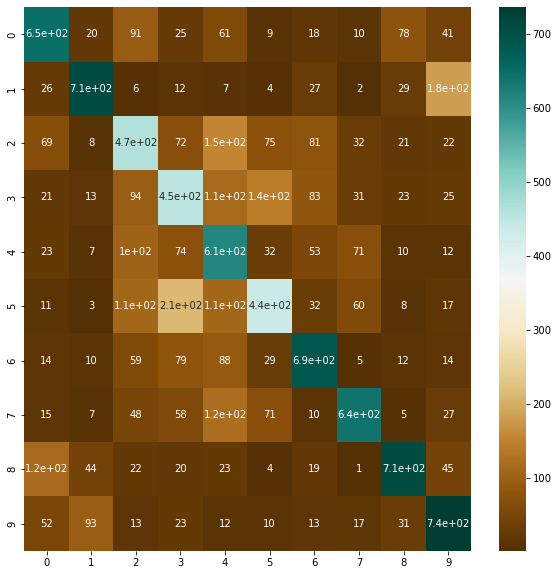

In [ ]:
cnn = build_CNN('cnn')
cnn = FC_net(cnn)
cnn.summary()
filepath = './model/'+ cnn.name 
cnn = compiling(model=cnn, optimizer='adam', loss='categorical_crossentropy')
if tf.io.gfile.exists(filepath):
  cnn.load_weights(filepath)
else:
  callbacks_list = [PlotLearning(report_every=20), EpochDots(report_every=10)]
  cnn = fitting(model=cnn, batch_size=256, callbacks_list=callbacks_list)
evaluation(model=cnn)

## ب

Model: "cnn_bathc_pool"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_6 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_13 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_7 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                    

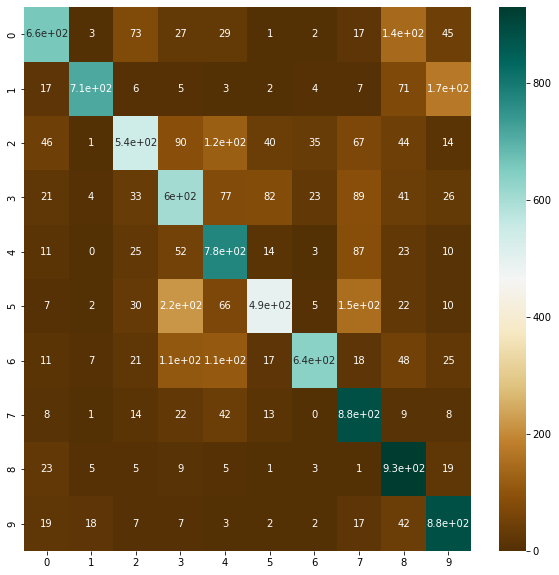

In [ ]:
cnn_bathc_pool = build_CNN(name='cnn_bathc_pool', has_batchNormalization=True, has_pooling=True)
cnn_bathc_pool = FC_net(cnn_bathc_pool)
cnn_bathc_pool.summary()
filepath = './model/'+ cnn_bathc_pool.name 
cnn_bathc_pool = compiling(model=cnn_bathc_pool, optimizer='adam', loss='categorical_crossentropy')
if tf.io.gfile.exists(filepath):
  cnn_bathc_pool.load_weights(filepath)
else:
  callbacks_list = [PlotLearning(report_every=20), EpochDots(report_every=10)]
  cnn_bathc_pool = fitting(model=cnn_bathc_pool, batch_size=256, callbacks_list=callbacks_list)
evaluation(model=cnn_bathc_pool)

## ج

Model: "cnn_dropout"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_18 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_19 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_19 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                       

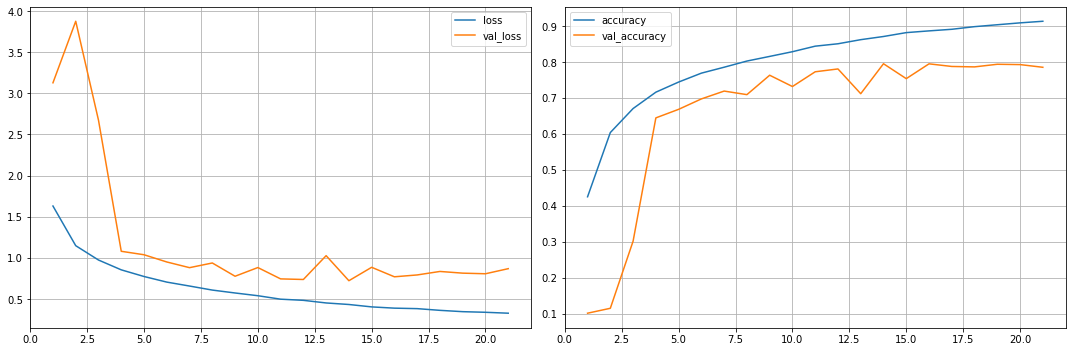


Epoch: 20, accuracy:0.9134, loss:0.3272, val_accuracy:0.7853, val_loss:0.8685, runtime : 7.58
..
Epoch: 22, accuracy:0.9217, loss:0.3081, val_accuracy:0.7985, val_loss:0.8532, runtime : 6.82
..
Runing Time :  259.269894361496 seconds
Train loss :0.2809
Train accuracy :0.93

Validation loss :0.7221
Validation accuracy :0.80

Test loss :0.7313
Test accuracy :0.80


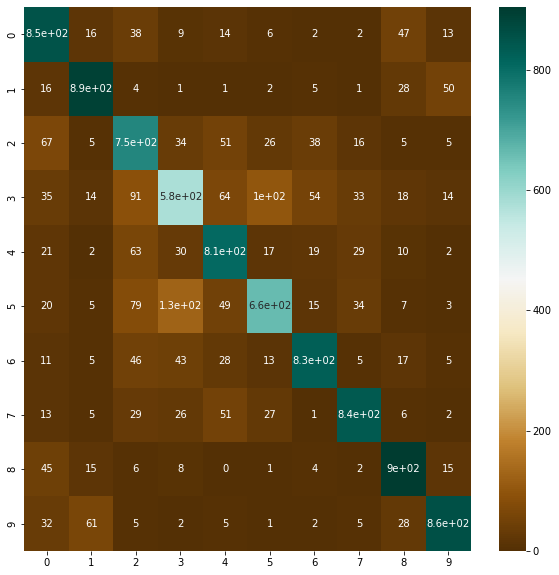

In [23]:
cnn_dropout= build_CNN(name='cnn_dropout', has_batchNormalization=True, has_pooling=True,
                       has_dropout=True, dropout_rate=0.2)
cnn_dropout = FC_net(cnn_dropout)
filepath = './model/'+ cnn_dropout.name 
cnn_dropout = compiling(model=cnn_dropout, optimizer='adam', loss='categorical_crossentropy')
if tf.io.gfile.exists(filepath):
  cnn_dropout.load_weights(filepath)
else:
  callbacks_list = [PlotLearning(report_every=20), EpochDots(report_every=2)]
  cnn_dropout = fitting(model=cnn_dropout, batch_size=256, callbacks_list=callbacks_list)
evaluation(model=cnn_dropout)
# plotting(model=cnn_dropout)

# Data Augmentation

## ب

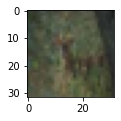

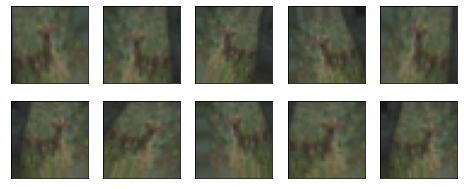

In [ ]:
from keras.preprocessing.image import ImageDataGenerator 
datagen = ImageDataGenerator( rotation_range=20, width_shift_range=0.1, height_shift_range=0.1, 
                         shear_range=0.2, zoom_range=0.2, horizontal_flip=True, 
                         fill_mode="nearest")
img_test = X[10].astype('float32')
img_test/=255
plt.figure(figsize=(1.6,1.6))
plt.imshow(img_test)
plt.show()
img_test = np.expand_dims(img_test,axis=0)
imGen = datagen.flow(img_test)

array_img_x =[]
fig = plt.figure(figsize=(8,3.2))
for i in range(10):
  ax = fig.add_subplot(2, 5, i + 1, xticks=[], yticks=[])
  batch = imGen.next()
  ax.imshow(batch[0])

## ج

In [17]:
def decrese_size_class(X_train, y_train, class_id, decrese_size):
    itemindex = np.where(y_train[:,class_id]==1)[0]
    np.random.shuffle(itemindex)
    remove_size = itemindex.size//decrese_size
    remove_index = itemindex[:-remove_size]
    X_new = np.delete(X_train, remove_index, axis=0)
    y_new = np.delete(y_train, remove_index, axis=0)
    return(X_new, y_new) 

In [18]:
print('shape X :', X.shape)
# y_oneHot = keras.utils.to_categorical(y, num_classes)
print('shape y :', y.shape)
X_unbalanced, y_unbalanced = decrese_size_class(X,y, class_id=3, decrese_size=10)
X_unbalanced, y_unbalanced = decrese_size_class(X_unbalanced,y_unbalanced,
                                                            class_id=5, decrese_size=10)
print('shape X unbalanced :', X_unbalanced.shape)
print('shape y unbalanced :', y_unbalanced.shape)

shape X : (50000, 32, 32, 3)
shape y : (50000, 10)
shape X unbalanced : (41000, 32, 32, 3)
shape y unbalanced : (41000, 10)


In [19]:
#split unbalanced data into training and validation sets 
from sklearn.model_selection import train_test_split 
X_train_unbalanced, X_valid_unbalanced, y_train_unbalanced, y_valid_unbalanced = train_test_split(
    X_unbalanced, y_unbalanced, test_size=0.2, random_state=43, shuffle=True)

#normalize
X_train_unbalanced = keras.utils.normalize(X_train_unbalanced, axis=1)
X_valid_unbalanced = keras.utils.normalize(X_valid_unbalanced, axis=1)
print('shape X_train_unbalanced:', X_train_unbalanced.shape)
print('shape X_valid_unbalanced:', X_valid_unbalanced.shape)
print('shape X_test:', X_test.shape)
print()
print('shape y_train_unbalanced:', y_train_unbalanced.shape)
print('shape y_valid_unbalanced:', y_valid_unbalanced.shape)
print('shape y_test:', y_test.shape)


shape X_train_unbalanced: (32800, 32, 32, 3)
shape X_valid_unbalanced: (8200, 32, 32, 3)
shape X_test: (10000, 32, 32, 3)

shape y_train_unbalanced: (32800, 10)
shape y_valid_unbalanced: (8200, 10)
shape y_test: (10000, 10)


Model: "cnn_unbalanced"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_12 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_13 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_13 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                    

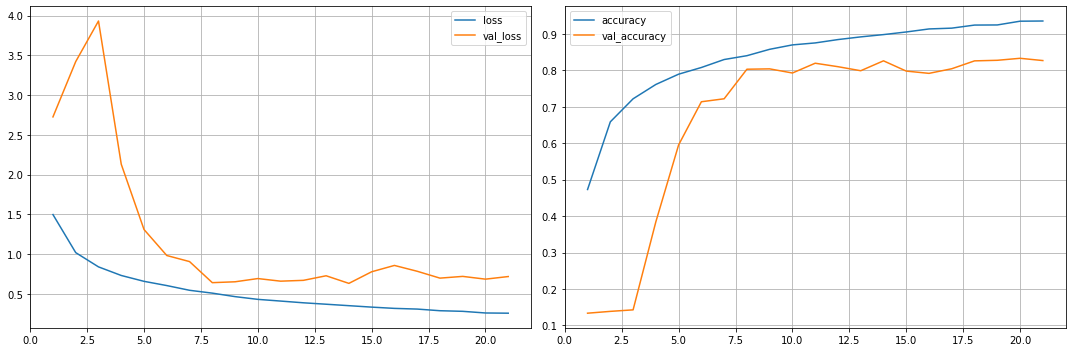


Epoch: 20, accuracy:0.9354, loss:0.2558, val_accuracy:0.8268, val_loss:0.7168, runtime : 6.34
..
Epoch: 22, accuracy:0.9434, loss:0.2391, val_accuracy:0.8230, val_loss:0.7429, runtime : 5.69
..
Runing Time :  208.14354968070984 seconds
Train loss :0.2391
Train accuracy :0.94

Validation loss :0.6309
Validation accuracy :0.83

Test loss :1.0702
Test accuracy :0.72


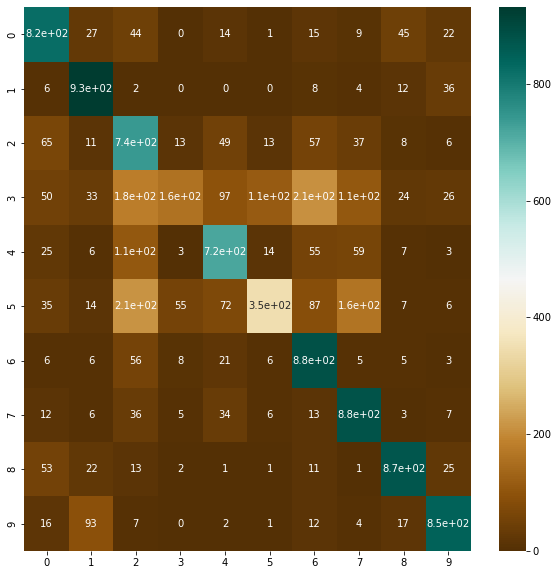

In [22]:
cnn_unbalanced= build_CNN(name='cnn_unbalanced', has_batchNormalization=True, has_pooling=True,
                       has_dropout=True, dropout_rate=0.2)
cnn_unbalanced = FC_net(cnn_unbalanced)
filepath = './model/'+ cnn_unbalanced.name 
cnn_unbalanced = compiling(model=cnn_unbalanced, optimizer='adam', loss='categorical_crossentropy')

if tf.io.gfile.exists(filepath):
  cnn_unbalanced.load_weights(filepath)
else:
  callbacks_list = [PlotLearning(report_every=20), EpochDots(report_every=2)]
  cnn_unbalanced = fitting(model=cnn_unbalanced,
                           batch_size=256, callbacks_list=callbacks_list,
                           X_train=X_train_unbalanced, y_train=y_train_unbalanced,
                           validation_data=(X_valid_unbalanced, y_valid_unbalanced))
                          #  X_train=X_train_unbalanced, y_train=y_train_unbalanced,
                          #  validation_data=(X_valid_unbalanced, y_valid_unbalanced))
evaluation(model=cnn_unbalanced,
           X_train=X_train_unbalanced, y_train=y_train_unbalanced,
           X_valid=X_valid_unbalanced, y_valid=y_valid_unbalanced)

## د